In [64]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit
import pandas as pd
import os
from importlib import reload

plt.style.use("../KD_style.mplstyle")

## Exercise 0

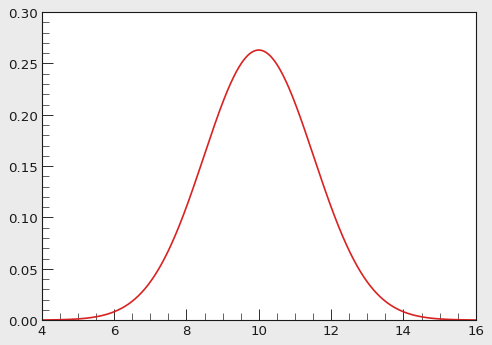

In [65]:
def gauss_pdf(x, mu, sigma):
    return stats.norm.pdf(x, mu, sigma)

mu_front = 10
sigma_front = np.sqrt(2.3)

x_front = np.arange(mu_front - 5 * sigma_front, mu_front + 5 * sigma_front, 0.01)
y_front = gauss_pdf(x_front, mu_front, sigma_front)
plt.plot(x_front, y_front)
xrange = (mu_front - 4 * sigma_front, mu_front + 4 * sigma_front)
plt.xlim(4, 16)
# plt.hlines(0, *xrange, color = "k", linewidth = 0.5)
plt.ylim(0, 0.3)
plt.grid(False)

## Exercise 1

In [66]:
def acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran < yfunc]
    ykeep = yran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest, all_xrest, all_yrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.array([])
        yrest = np.array([])
        all_xrest = np.array([])
        all_yrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    allx = np.append(xran, all_xrest)
    ally = np.append(yran, all_yrest)
    finaltries = N_points + tries
    return finalx, finaly, allx, ally, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    x, y, all_x, all_y, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, y, area, all_x, all_y, eff, tries

(0.0, 1.1)

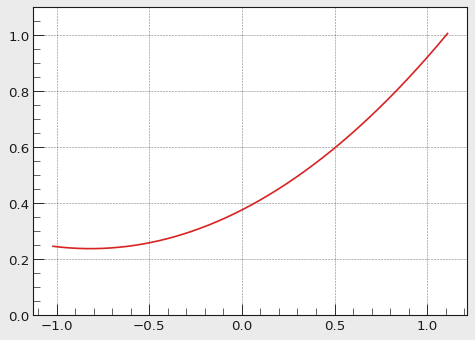

In [67]:
def num_int1(func, xmin, xmax, points = 100000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    area = np.sum(func(x, **kwargs))/points*(xmax-xmin)
    return area

def num_int2(func, xmin, xmax, points = 1000000, **kwargs):
    # This method is better than num_int1
    x = np.linspace(xmin, xmax, points)
    y = func(x, **kwargs)
    y_ave = y[1:] + (y[1:] - y[:-1])/2
    width = (xmax-xmin)/(points-1)
    area = np.sum(y_ave)*width
    return area

def try_pdf1(x, norm, a, b):
    return norm * (1 + a*x + b*x**2) 

a = 0.9
b = 0.55

xmin = -1.02
xmax = 1.11

area = num_int2(try_pdf1, xmin, xmax, norm = 1, a = a, b = b)
norm1 = 1/area
# print(norm1) # norm = 0.3757200028849609
# area = num_int2(try_pdf1, xmin, xmax, norm = norm1, a = a, b = b)
# print(area) # area = 0.9999999999999999, real area = 0.999998
xquick = np.linspace(xmin, xmax, 10000)
yquick = try_pdf1(xquick, norm1, a, b)
plt.plot(xquick, yquick)
plt.ylim(0,1.1)


1.0067915401603995


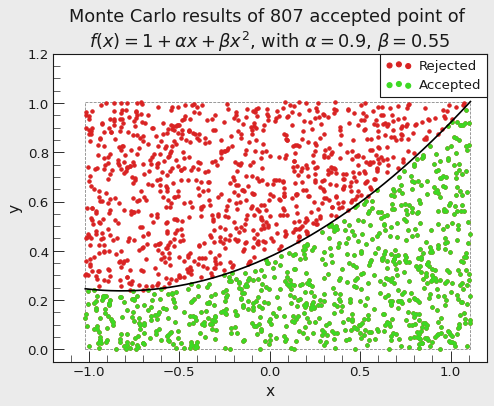

In [128]:
xmin = -1.02
xmax = 1.11
ymin = 0
ymax = try_pdf1(xmax, norm1, a, b)

N_accept = 807


xquick = np.linspace(xmin, xmax, 10000)
yquick = try_pdf1(xquick, norm1, a, b)
x, y, area, allx, ally ,_,_ = acceptrejectdata(try_pdf1, xmin, xmax, ymin, ymax, N_accept, norm = norm1, a = a, b = b)

print(area)
plt.plot(xquick, yquick, color = "k")
plt.scatter(allx, ally, label = "Rejected")
plt.scatter(x,y, color = "#3dd923", label = "Accepted")
plt.grid(False)
plt.hlines(ymin, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.hlines(ymax, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmin, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmax, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.ylim(-0.05, 1.2)
plt.xlim(-1.2, 1.2)
plt.legend(scatterpoints = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 807 accepted point of \n" + r"$f(x) = 1 + \alpha x + \beta x^{2}$, with $\alpha = 0.9$, $\beta = 0.55$")
plt.savefig("./montecarlo_poly_1.pdf", facecolor = "white")
plt.show()

pd.DataFrame(np.array([x, y]).T, columns = ["x", "y"]).to_csv("./Kofoeddjursner_polynomial.txt" , index = None)

1.0000003244612425
0.20458816554858644
1.0294627653401163


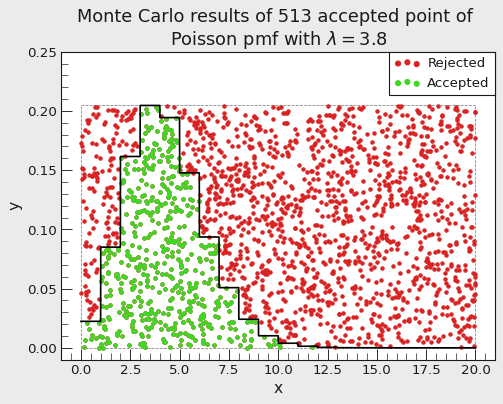

In [127]:
def poisson_pmf(x, norm, lamb):
    return norm * stats.poisson.pmf(np.floor(x), lamb)

xmin = 0
xmax = 20

lamb = 3.8
poi_norm = num_int2(poisson_pmf, xmin, xmax, norm = 1, lamb = lamb)
print(poi_norm) # num int gives 1.0000003. real int is 


ymin = 0
ymax = poisson_pmf(lamb, 1, lamb)
print(ymax)
N_accept = 513

xquick = np.linspace(xmin, xmax, 10000)
yquick = poisson_pmf(xquick, poi_norm, lamb)

x, y, area, allx, ally ,_,_ = acceptrejectdata(poisson_pmf, xmin, xmax, ymin, ymax, N_accept, norm = poi_norm, lamb = lamb)
print(area)
plt.plot(xquick, yquick, color = "k")
plt.scatter(allx, ally, label = "Rejected")
plt.scatter(x,y, color = "#3dd923", label = "Accepted")
plt.grid(False)
plt.hlines(ymin, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.hlines(ymax, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmin, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmax, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.ylim(-0.01, 0.25)
# plt.xlim(-1.2, 1.2)
plt.legend(scatterpoints = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 513 accepted point of \n" + r"Poisson pmf with $\lambda = 3.8$")
plt.savefig("./montecarlo_poisson_1.pdf", facecolor = "white")
plt.show()

pd.DataFrame(np.array([x, y]).T, columns = ["x", "y"]).to_csv("./Kofoeddjursner_poisson.txt" , index = None)

In [ ]:
# Nan siger: linjen skal være tykkere og punkterne mindre 